In [ ]:

import pandas as pd
import numpy as np
import random 
from sklearn.preprocessing import LabelEncoder
import optuna
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

CSV_PATH="cleaned_songs.csv"
df=pd.read_csv(CSV_PATH)
random_seed=47

Num GPUs Available:  0
Epoch 1/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2102 - loss: 3.1491
Epoch 2/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5104 - loss: 2.2630
Epoch 3/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8315 - loss: 1.2827
Epoch 4/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9575 - loss: 0.7322
Epoch 5/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9900 - loss: 0.5309
Epoch 6/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9983 - loss: 0.4236
Epoch 7/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.3527
Epoch 8/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9992 - loss: 0.3031
Epoch 9/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.2699
Epoch 10/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.2440
Epoch 11/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.2235
Epoch 12/14
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

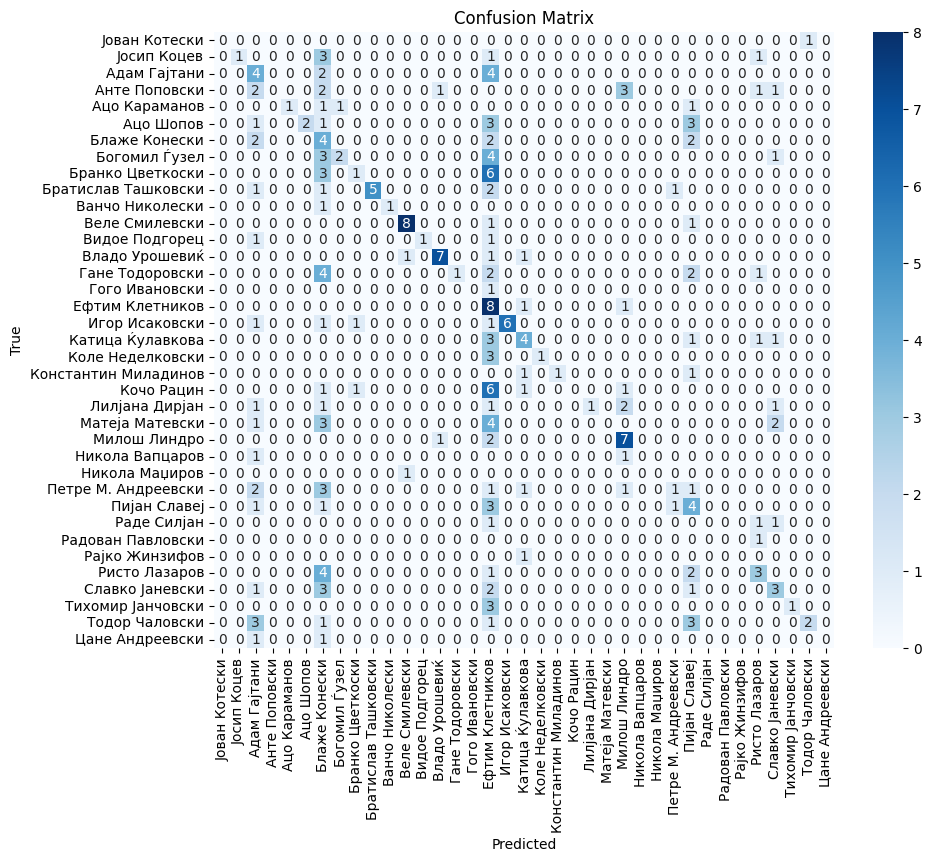

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # Explicitly disable GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

best_params = {
    'max_features': 2000,
    'n_layers': 1,
    'neurons': 228,
    'activation': 'tanh',
    'dropout_rate': 0.11084515268749309,
    'optimizer': 'adam',
    'lr': 0.00503887829334363,
    'l2_reg': 0.00010248432412205469,
    'n_epochs': 14
}

TRAIN_CSV = "cleaned_songs.csv"
df_train = pd.read_csv(TRAIN_CSV)
df_train['song_text'] = df_train['song_text'].str.lower()
vectorizer = TfidfVectorizer(
    max_features=best_params['max_features'], ngram_range=(1,2), min_df=2, max_df=0.8
)
X_train = vectorizer.fit_transform(df_train['song_text']).toarray()
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['author'])
num_classes = len(label_encoder.classes_)
X_train = np.expand_dims(X_train, axis=1)

model = keras.Sequential()
model.add(layers.Input(shape=(1, X_train.shape[2])))
for i in range(best_params['n_layers']):
    return_sequences = i < best_params['n_layers'] - 1
    model.add(layers.LSTM(
        best_params['neurons'],
        activation=best_params['activation'],
        kernel_regularizer=regularizers.l2(best_params['l2_reg']),
        return_sequences=return_sequences
    ))
model.add(layers.Dropout(best_params['dropout_rate']))
model.add(layers.Dense(num_classes, activation="softmax"))
optimizer = keras.optimizers.Adam(learning_rate=best_params['lr'])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model.fit(X_train, y_train, epochs=best_params['n_epochs'], batch_size=32, verbose=1)

EVAL_CSV = "../author_songs_created_using_styles_idf.csv"
df_eval = pd.read_csv(EVAL_CSV)
df_eval['new_song'] = df_eval['new_song'].str.lower()
X_eval = vectorizer.transform(df_eval['new_song']).toarray()
X_eval = np.expand_dims(X_eval, axis=1)
mask = df_eval['author'].isin(label_encoder.classes_)
X_eval = X_eval[mask.values]
y_eval = df_eval['author'][mask].values
y_eval_encoded = label_encoder.transform(y_eval)

y_pred = np.argmax(model.predict(X_eval, verbose=0), axis=1)
f1 = f1_score(y_eval_encoded, y_pred, average="weighted")
print("F1 score on evaluation dataset:", f1)
cm = confusion_matrix(y_eval_encoded, y_pred)
f1_per_author = f1_score(y_eval_encoded, y_pred, average=None)
print("\nF1 score per author:")
for author, f1_val in zip(label_encoder.classes_, f1_per_author):
    print(f"{author}: {f1_val:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Num GPUs Available:  0
Epoch 1/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1743 - loss: 3.3266
Epoch 2/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2811 - loss: 2.8018
Epoch 3/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3770 - loss: 2.5085
Epoch 4/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4654 - loss: 2.2056
Epoch 5/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6155 - loss: 1.8889
Epoch 6/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7606 - loss: 1.5652
Epoch 7/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8424 - loss: 1.2646
Epoch 8/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8932 - loss: 0.9935
Epoch 9/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9283 - loss: 0.7693
Epoch 10/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9425 - loss: 0.5944
Epoch 11/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9591 - loss: 0.4537
Epoch 12/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

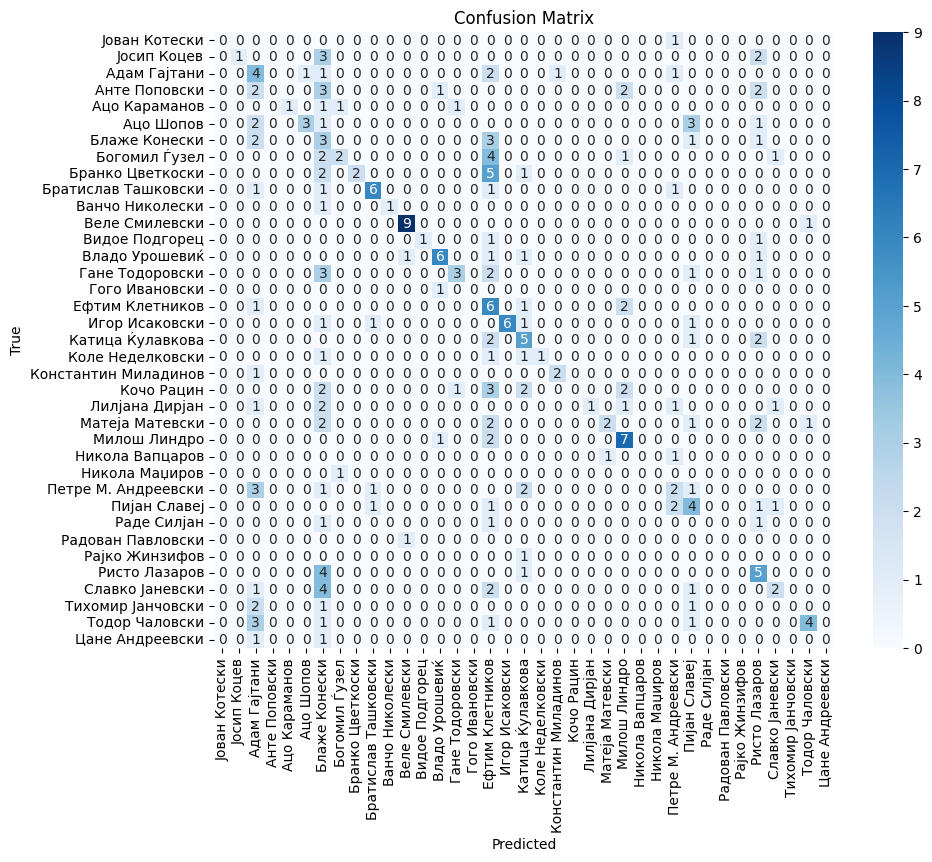

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # Explicitly disable GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


best_params = {
    'max_features': 4619,
    'n_layers': 1,
    'neurons': 567,
    'activation': 'tanh',
    'dropout_rate': 0.3406819279083615,
    'optimizer': 'rmsprop',
    'lr': 0.0007878787378953067,
    'l2_reg': 3.145848564707723e-05,
    'n_epochs': 41,
    'min_df': 3,
    'max_df': 0.8904674508605334,
    'ngram_range': (1, 1)
}


TRAIN_CSV = "cleaned_songs.csv"
df_train = pd.read_csv(TRAIN_CSV)
df_train['song_text'] = df_train['song_text'].str.lower()


vectorizer = TfidfVectorizer(
    max_features=best_params['max_features'],
    ngram_range=best_params['ngram_range'],
    min_df=best_params['min_df'],
    max_df=best_params['max_df']
)
X_train = vectorizer.fit_transform(df_train['song_text']).toarray()


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['author'])
num_classes = len(label_encoder.classes_)


model = keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1],)))
for i in range(best_params['n_layers']):
    model.add(layers.Dense(
        best_params['neurons'],
        activation=best_params['activation'],
        kernel_regularizer=regularizers.l2(best_params['l2_reg'])
    ))
    model.add(layers.Dropout(best_params['dropout_rate']))
model.add(layers.Dense(num_classes, activation="softmax"))


optimizer = keras.optimizers.RMSprop(learning_rate=best_params['lr'])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])


model.fit(X_train, y_train, epochs=best_params['n_epochs'], batch_size=32, verbose=1)


EVAL_CSV = "../author_songs_created_using_styles_idf.csv"
df_eval = pd.read_csv(EVAL_CSV)
df_eval['new_song'] = df_eval['new_song'].str.lower()
X_eval = vectorizer.transform(df_eval['new_song']).toarray()
mask = df_eval['author'].isin(label_encoder.classes_)
X_eval = X_eval[mask.values]
y_eval = df_eval['author'][mask].values
y_eval_encoded = label_encoder.transform(y_eval)


y_pred = np.argmax(model.predict(X_eval, verbose=0), axis=1)
f1 = f1_score(y_eval_encoded, y_pred, average="weighted")
print("F1 score on evaluation dataset:", f1)
cm = confusion_matrix(y_eval_encoded, y_pred)
f1_per_author = f1_score(y_eval_encoded, y_pred, average=None)
print("\nF1 score per author:")
for author, f1_val in zip(label_encoder.classes_, f1_per_author):
    print(f"{author}: {f1_val:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [7]:
print(df_train['author'].value_counts())

author
Блаже Конески           182
Пијан Славеј            160
Ефтим Клетников         135
Славко Јаневски          70
Владо Урошевиќ           61
Катица Ќулавкова         60
Братислав Ташковски      55
Веле Смилевски           51
Ристо Лазаров            48
Адам Гајтани             47
Бранко Цветкоски         41
Петре М. Андреевски      41
Милош Линдро             40
Тодор Чаловски           31
Ацо Шопов                31
Анте Поповски            21
Гане Тодоровски          19
Богомил Ѓузел            19
Игор Исаковски           15
Матеја Матевски          14
Кочо Рацин               13
Лилјана Дирјан            7
Јосип Коцев               6
Ацо Караманов             4
Тихомир Јанчовски         4
Коле Неделковски          4
Видое Подгорец            3
Раде Силјан               3
Константин Миладинов      3
Цане Андреевски           2
Ванчо Николески           2
Никола Вапцаров           2
Рајко Жинзифов            1
Никола Маџиров            1
Јован Котески             1
Радован Павло

In [8]:
print(df_eval['author'].value_counts())

author
Петре М. Андреевски     10
Кочо Рацин              10
Гане Тодоровски         10
Владо Урошевиќ          10
Блаже Конески           10
Ристо Лазаров           10
Славко Јаневски         10
Ацо Шопов               10
Анте Поповски           10
Матеја Матевски         10
Игор Исаковски          10
Богомил Ѓузел           10
Катица Ќулавкова        10
Тодор Чаловски          10
Милош Линдро            10
Бранко Цветкоски        10
Пијан Славеј            10
Братислав Ташковски     10
Ефтим Клетников         10
Адам Гајтани            10
Веле Смилевски          10
Лилјана Дирјан           7
Јосип Коцев              6
Ацо Караманов            4
Тихомир Јанчовски        4
Коле Неделковски         4
Видое Подгорец           3
Раде Силјан              3
Константин Миладинов     3
Цане Андреевски          2
Ванчо Николески          2
Никола Вапцаров          2
Рајко Жинзифов           1
Никола Маџиров           1
Јован Котески            1
Радован Павловски        1
Гого Ивановски       

In [9]:
song_counts = df_train['author'].value_counts()

n=3
few_songs = song_counts[song_counts < n]

# Print them
print(f"Authors with fewer than {n} songs:")
print(few_songs)

Authors with fewer than 3 songs:
author
Цане Андреевски      2
Ванчо Николески      2
Никола Вапцаров      2
Рајко Жинзифов       1
Никола Маџиров       1
Јован Котески        1
Радован Павловски    1
Гого Ивановски       1
Name: count, dtype: int64


With removed less representative authors 

Num GPUs Available: 0
Training set size after filtering: 1190
Epoch 1/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.1933 - loss: 3.1782
Epoch 2/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3294 - loss: 2.7350
Epoch 3/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3790 - loss: 2.4431
Epoch 4/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4782 - loss: 2.1354
Epoch 5/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6471 - loss: 1.8073
Epoch 6/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7571 - loss: 1.4776
Epoch 7/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8496 - loss: 1.1737
Epoch 8/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9101 - loss: 0.9056
Epoch 9/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9412 - loss: 0.6894
Epoch 10/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9588 - loss: 0.5171
Epoch 11/41
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9756 - loss: 0.3946
Epoch 12/41


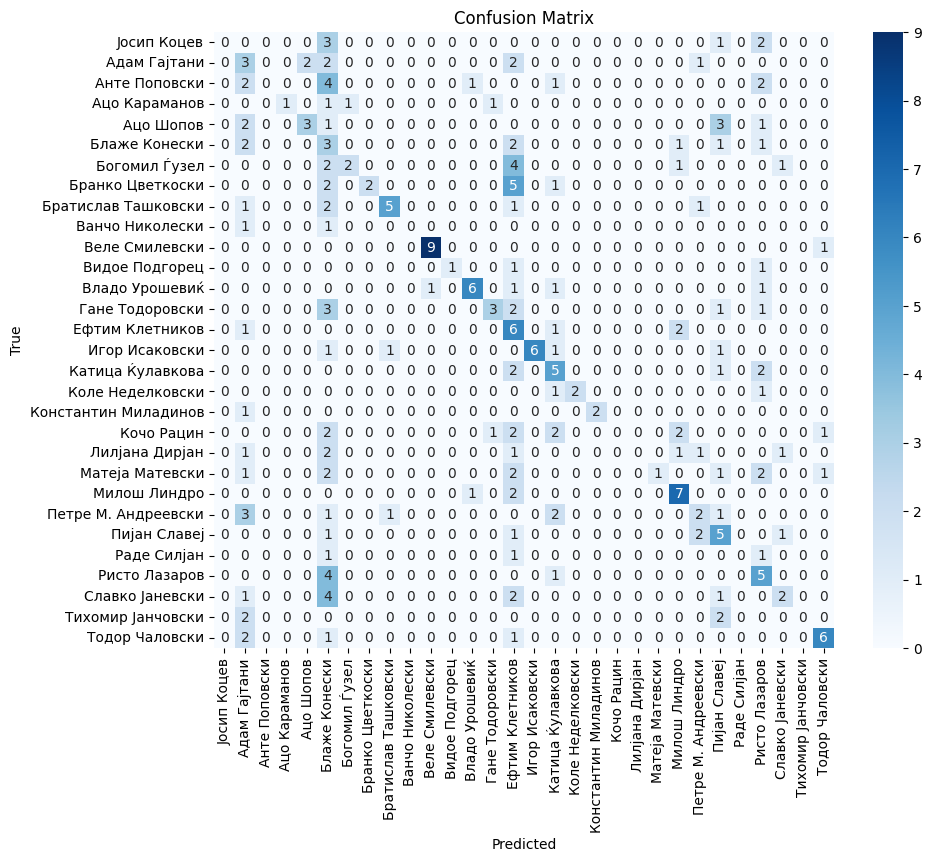

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # Explicitly disable GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# === Best hyperparameters (from your search) ===
best_params = {
    'max_features': 4619,
    'n_layers': 1,
    'neurons': 567,
    'activation': 'tanh',
    'dropout_rate': 0.3406819279083615,
    'optimizer': 'rmsprop',
    'lr': 0.0007878787378953067,
    'l2_reg': 3.145848564707723e-05,
    'n_epochs': 41,
    'min_df': 3,
    'max_df': 0.8904674508605334,
    'ngram_range': (1, 1)
}


authors_to_remove = [
    "Јован Котески",
    "Гого Ивановски",
    "Никола Маџиров",
    "Никола Вапцаров",
    "Радован Павловски",
    "Рајко Жинзифов",
    "Цане Андреевски"
]


TRAIN_CSV = "cleaned_songs.csv"
df_train = pd.read_csv(TRAIN_CSV)
df_train['song_text'] = df_train['song_text'].str.lower()

# Remove authors with too few songs
df_train = df_train[~df_train['author'].isin(authors_to_remove)]
print(f"Training set size after filtering: {len(df_train)}")

# TF-IDF vectorization
vectorizer = TfidfVectorizer(
    max_features=best_params['max_features'],
    ngram_range=best_params['ngram_range'],
    min_df=best_params['min_df'],
    max_df=best_params['max_df']
)
X_train = vectorizer.fit_transform(df_train['song_text']).toarray()

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['author'])
num_classes = len(label_encoder.classes_)


# === Build model ===
model = keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1],)))

for i in range(best_params['n_layers']):
    model.add(layers.Dense(
        best_params['neurons'],
        activation=best_params['activation'],
        kernel_regularizer=regularizers.l2(best_params['l2_reg'])
    ))
    model.add(layers.Dropout(best_params['dropout_rate']))

model.add(layers.Dense(num_classes, activation="softmax"))

optimizer = keras.optimizers.RMSprop(learning_rate=best_params['lr'])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model.fit(X_train, y_train, epochs=best_params['n_epochs'], batch_size=32, verbose=1)


EVAL_CSV = "../author_songs_created_using_styles_idf.csv"
df_eval = pd.read_csv(EVAL_CSV)
df_eval['new_song'] = df_eval['new_song'].str.lower()

df_eval = df_eval[~df_eval['author'].isin(authors_to_remove)]
print(f"Evaluation set size after filtering: {len(df_eval)}")

X_eval = vectorizer.transform(df_eval['new_song']).toarray()
mask = df_eval['author'].isin(label_encoder.classes_)
X_eval = X_eval[mask.values]
y_eval = df_eval['author'][mask].values
y_eval_encoded = label_encoder.transform(y_eval)


y_pred = np.argmax(model.predict(X_eval, verbose=0), axis=1)

f1_weighted = f1_score(y_eval_encoded, y_pred, average="weighted")
print("\nWeighted F1 score on evaluation dataset:", f1_weighted)

f1_per_author = f1_score(y_eval_encoded, y_pred, average=None)
print("\nF1 score per author:")
for author, f1_val in zip(label_encoder.classes_, f1_per_author):
    print(f"{author}: {f1_val:.4f}")

cm = confusion_matrix(y_eval_encoded, y_pred)


plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Atleast 10 songs per author

Num GPUs Available: 0
Training set size after filtering: 1154
Number of authors kept: 21
Epoch 1/41
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1664 - loss: 2.9061
Epoch 2/41
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3137 - loss: 2.5582
Epoch 3/41
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4064 - loss: 2.2661
Epoch 4/41
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5277 - loss: 1.9414
Epoch 5/41
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6984 - loss: 1.5949
Epoch 6/41
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8250 - loss: 1.2591
Epoch 7/41
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9246 - loss: 0.9609
Epoch 8/41
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9584 - loss: 0.7126
Epoch 9/41
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9757 - loss: 0.5218
Epoch 10/41
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9887 - loss: 0.3746
Epoch 11/41
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9931 

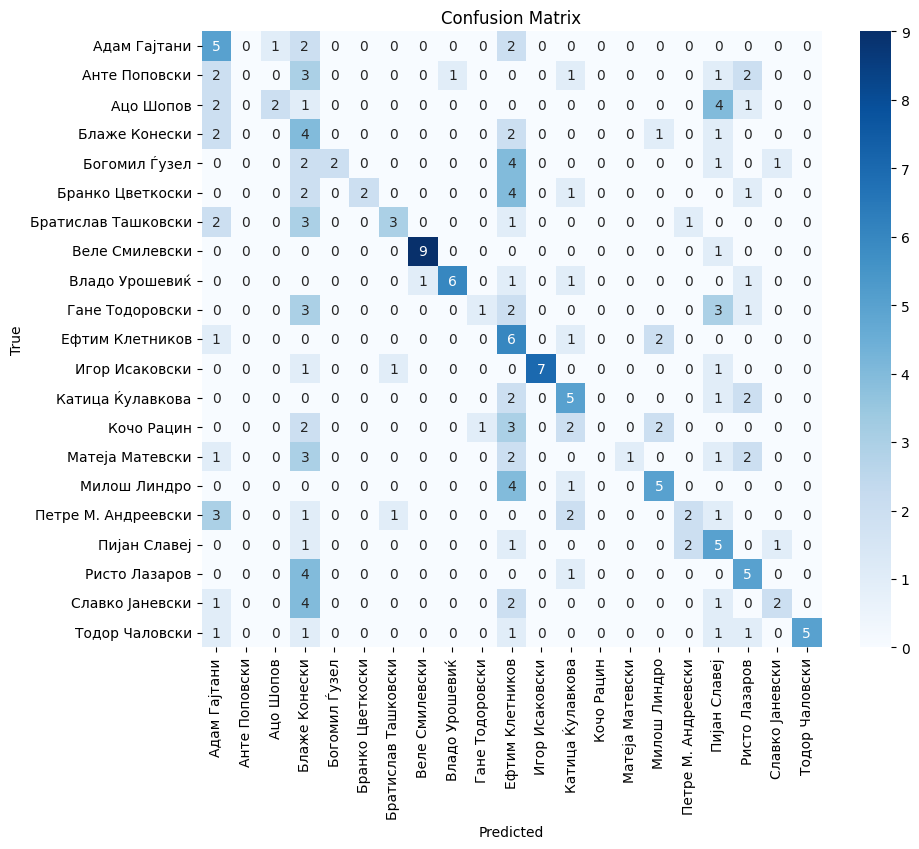

In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')  # Explicitly disable GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# === Best hyperparameters (from your search) ===
best_params = {
    'max_features': 4619,
    'n_layers': 1,
    'neurons': 567,
    'activation': 'tanh',
    'dropout_rate': 0.3406819279083615,
    'optimizer': 'rmsprop',
    'lr': 0.0007878787378953067,
    'l2_reg': 3.145848564707723e-05,
    'n_epochs': 41,
    'min_df': 3,
    'max_df': 0.8904674508605334,
    'ngram_range': (1, 1)
}


# === Load and filter training data ===
TRAIN_CSV = "cleaned_songs.csv"
df_train = pd.read_csv(TRAIN_CSV)
df_train['song_text'] = df_train['song_text'].str.lower()

# Keep only authors with at least 10 songs
author_counts = df_train['author'].value_counts()
valid_authors = author_counts[author_counts >= 10].index
df_train = df_train[df_train['author'].isin(valid_authors)]
print(f"Training set size after filtering: {len(df_train)}")
print(f"Number of authors kept: {len(valid_authors)}")

# === TF-IDF Vectorization ===
vectorizer = TfidfVectorizer(
    max_features=best_params['max_features'],
    ngram_range=best_params['ngram_range'],
    min_df=best_params['min_df'],
    max_df=best_params['max_df']
)
X_train = vectorizer.fit_transform(df_train['song_text']).toarray()

# === Encode labels ===
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['author'])
num_classes = len(label_encoder.classes_)


# === Build the model ===
model = keras.Sequential()
model.add(layers.Input(shape=(X_train.shape[1],)))

for i in range(best_params['n_layers']):
    model.add(layers.Dense(
        best_params['neurons'],
        activation=best_params['activation'],
        kernel_regularizer=regularizers.l2(best_params['l2_reg'])
    ))
    model.add(layers.Dropout(best_params['dropout_rate']))

model.add(layers.Dense(num_classes, activation="softmax"))

optimizer = keras.optimizers.RMSprop(learning_rate=best_params['lr'])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

# === Train ===
model.fit(X_train, y_train, epochs=best_params['n_epochs'], batch_size=32, verbose=1)


# === Evaluation ===
EVAL_CSV = "../author_songs_created_using_styles_idf.csv"
df_eval = pd.read_csv(EVAL_CSV)
df_eval['new_song'] = df_eval['new_song'].str.lower()

# Keep only authors that are in the filtered training set
df_eval = df_eval[df_eval['author'].isin(label_encoder.classes_)]
print(f"Evaluation set size after filtering: {len(df_eval)}")

X_eval = vectorizer.transform(df_eval['new_song']).toarray()
y_eval = df_eval['author'].values
y_eval_encoded = label_encoder.transform(y_eval)

# === Predict and evaluate ===
y_pred = np.argmax(model.predict(X_eval, verbose=0), axis=1)

f1_weighted = f1_score(y_eval_encoded, y_pred, average="weighted")
print("\nWeighted F1 score on evaluation dataset:", f1_weighted)

f1_per_author = f1_score(y_eval_encoded, y_pred, average=None)
print("\nF1 score per author:")
for author, f1_val in zip(label_encoder.classes_, f1_per_author):
    print(f"{author}: {f1_val:.4f}")

# === Confusion Matrix ===
cm = confusion_matrix(y_eval_encoded, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Tryting to predict generated or real

Num GPUs Available: 0
Combined dataset size: 1454
Dataset size after filtering authors with <10 samples: 1390
Remaining authors: 23


Model: "functional_24"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 4619)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 567)       │  2,619,540 │ input_layer_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 567)       │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ author_output       │ (None, 23)        │     13,064 │ dropout_8[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generated_output    │ (None, 1)         │        568 │ dropout_8[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,633,172 (10.04 MB)

 Trainable params: 2,633,172 (10.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/41
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - author_output_accuracy: 0.1820 - author_output_loss: 2.9878 - generated_output_accuracy: 0.8420 - generated_output_loss: 0.4455 - loss: 3.4798 - val_author_output_accuracy: 0.1429 - val_author_output_loss: 2.9314 - val_generated_output_accuracy: 0.8393 - val_generated_output_loss: 0.3225 - val_loss: 3.2899
Epoch 2/41
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - author_output_accuracy: 0.2780 - author_output_loss: 2.7009 - generated_output_accuracy: 0.8730 - generated_output_loss: 0.2506 - loss: 2.9848 - val_author_output_accuracy: 0.2054 - val_author_output_loss: 2.8317 - val_generated_output_accuracy: 0.9018 - val_generated_output_loss: 0.2072 - val_loss: 3.0743
Epoch 3/41
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - author_output_accuracy: 0.3610 - author_output_loss: 2.4664 - generated_output_accuracy: 0.9600 - generated_output_loss: 0.1465 - loss: 2.6461 - val_author_output_accuracy: 0.2321 - val_author_output_loss: 2.7134 - val_generate

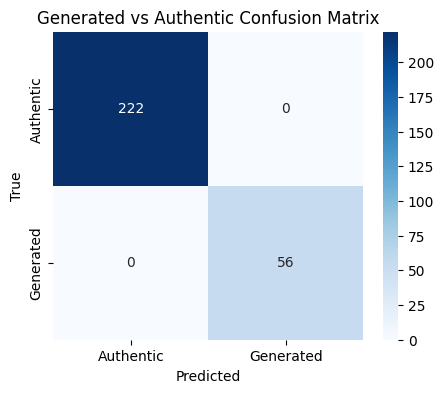

In [14]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# === Best hyperparameters (reuse from before) ===
best_params = {
    'max_features': 4619,
    'n_layers': 1,
    'neurons': 567,
    'activation': 'tanh',
    'dropout_rate': 0.3406819279083615,
    'optimizer': 'rmsprop',
    'lr': 0.0007878787378953067,
    'l2_reg': 3.145848564707723e-05,
    'n_epochs': 41,
    'min_df': 3,
    'max_df': 0.8904674508605334,
    'ngram_range': (1, 1)
}


# === Load datasets ===
train_csv = "cleaned_songs.csv"
eval_csv = "../author_songs_created_using_styles_idf.csv"

df_authentic = pd.read_csv(train_csv)
df_authentic['song_text'] = df_authentic['song_text'].str.lower()
df_authentic['is_generated'] = 0  # Authentic songs

df_generated = pd.read_csv(eval_csv)
df_generated['new_song'] = df_generated['new_song'].str.lower()
df_generated.rename(columns={'new_song': 'song_text'}, inplace=True)
df_generated['is_generated'] = 1  # Generated songs

# Combine datasets
df_all = pd.concat([df_authentic[['song_text', 'author', 'is_generated']],
                    df_generated[['song_text', 'author', 'is_generated']]],
                   ignore_index=True)

print(f"Combined dataset size: {len(df_all)}")


# === Filter out authors with too few examples (optional but recommended) ===
author_counts = df_all['author'].value_counts()
valid_authors = author_counts[author_counts >= 10].index
df_all = df_all[df_all['author'].isin(valid_authors)]
print(f"Dataset size after filtering authors with <10 samples: {len(df_all)}")
print(f"Remaining authors: {len(valid_authors)}")


# === Vectorize text ===
vectorizer = TfidfVectorizer(
    max_features=best_params['max_features'],
    ngram_range=best_params['ngram_range'],
    min_df=best_params['min_df'],
    max_df=best_params['max_df']
)
X = vectorizer.fit_transform(df_all['song_text']).toarray()

# === Encode labels ===
label_encoder = LabelEncoder()
y_author = label_encoder.fit_transform(df_all['author'])
y_generated = df_all['is_generated'].values



X_train, X_test, y_auth_train, y_auth_test, y_gen_train, y_gen_test = train_test_split(
    X, y_author, y_generated, test_size=0.2, random_state=42, stratify=y_author
)


# === Build dual-output model ===
input_layer = layers.Input(shape=(X_train.shape[1],))

x = input_layer
for i in range(best_params['n_layers']):
    x = layers.Dense(
        best_params['neurons'],
        activation=best_params['activation'],
        kernel_regularizer=regularizers.l2(best_params['l2_reg'])
    )(x)
    x = layers.Dropout(best_params['dropout_rate'])(x)

# Two separate heads
author_output = layers.Dense(len(label_encoder.classes_), activation="softmax", name="author_output")(x)
generated_output = layers.Dense(1, activation="sigmoid", name="generated_output")(x)

model = keras.Model(inputs=input_layer, outputs=[author_output, generated_output])

optimizer = keras.optimizers.RMSprop(learning_rate=best_params['lr'])
model.compile(
    optimizer=optimizer,
    loss={
        "author_output": "sparse_categorical_crossentropy",
        "generated_output": "binary_crossentropy"
    },
    metrics={
        "author_output": "accuracy",
        "generated_output": "accuracy"
    }
)

model.summary()

# === Train ===
history = model.fit(
    X_train,
    {"author_output": y_auth_train, "generated_output": y_gen_train},
    validation_split=0.1,
    epochs=best_params['n_epochs'],
    batch_size=32,
    verbose=1
)


# === Evaluate ===
pred_auth, pred_gen = model.predict(X_test, verbose=0)
y_auth_pred = np.argmax(pred_auth, axis=1)
y_gen_pred = (pred_gen > 0.5).astype(int).flatten()

print("\n=== Generated vs Authentic Classification ===")
print(classification_report(y_gen_test, y_gen_pred, target_names=["Authentic", "Generated"]))

print("\n=== Author Prediction ===")
print(classification_report(y_auth_test, y_auth_pred, target_names=label_encoder.classes_))

# Weighted F1 for both
f1_author = f1_score(y_auth_test, y_auth_pred, average="weighted")
f1_gen = f1_score(y_gen_test, y_gen_pred, average="weighted")
print(f"\nWeighted F1 - Author: {f1_author:.4f}, Generated/Authentic: {f1_gen:.4f}")


# === Confusion matrix for authenticity ===
cm_gen = tf.math.confusion_matrix(y_gen_test, y_gen_pred).numpy()
plt.figure(figsize=(5,4))
sns.heatmap(cm_gen, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Authentic", "Generated"], yticklabels=["Authentic", "Generated"])
plt.title('Generated vs Authentic Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [15]:
import joblib

# Save model and encoders
model.save("dual_model.keras")
joblib.dump(vectorizer, "vectorizer.pkl")
joblib.dump(label_encoder, "label_encoder.pkl")

print("Model and encoders saved successfully.")


Model and encoders saved successfully.


In [3]:
import tensorflow as tf
from tensorflow import keras
import joblib
import numpy as np

# === Load model and preprocessing objects ===
model = keras.models.load_model("dual_model.keras")
vectorizer = joblib.load("vectorizer.pkl")
label_encoder = joblib.load("label_encoder.pkl")

def evaluate_song(song_text):
    """
    Evaluates a given song to determine:
      - Whether it's generated or authentic
      - Who is the most likely author
    """
    # Preprocess text
    song_text = song_text.lower()
    X = vectorizer.transform([song_text]).toarray()

    # Predict both outputs
    author_pred, gen_pred = model.predict(X, verbose=0)
    predicted_author = label_encoder.inverse_transform([np.argmax(author_pred)])[0]
    is_generated = (gen_pred[0][0] > 0.5)

    authenticity = "Generated" if is_generated else "Authentic"

    print(f"\nPredicted Author: {predicted_author}")
    print(f"Authenticity: {authenticity} ({gen_pred[0][0]:.3f} confidence)")

    return predicted_author, authenticity


test_song = """Сенка на минатото


Беше таа, меѓу сите, нејзината сенка што се вткаа
во денови што се втиснаа во сеќавање.
Првата, пред погледите, оти нејзината моќ
ја привлекуваше погледите на сите.

Мојата душа, во тага, се губи во времето,
во мигови што оставија траги на нејзиното лице.
Нејзината култура, нејзината убавина, нејзината привлечност -
сè тоа сега е само сенка на минатото.

Животот, кој некогаш беше толку жив,
сега е само тага, само жал за изгубеното.
Очите, што некогаш гледаа во иднината,
сега се затворени пред реалноста на смртта.

Но, во таа сенка, во тоа минато,
сè уште постои искра на надеж,
искра што ветува дека времето ќе го врати
она што некогаш беше, и што повторно ќе биде.

"""
evaluate_song(test_song)



Predicted Author: Петре М. Андреевски
Authenticity: Authentic (0.124 confidence)


('Петре М. Андреевски', 'Authentic')

Num GPUs Available: 0
Authentic songs after limiting: 255
Generated songs after limiting: 255
Combined dataset size after limiting: 510
Combined dataset size: 510
Dataset size after filtering authors with <10 samples: 446
Remaining authors: 23


/tmp/ipykernel_11389/2126958007.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("author", group_keys=False).apply(lambda x: x.sample(n=min(len(x), max_per_author), random_state=42))
/tmp/ipykernel_11389/2126958007.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("author", group_keys=False).apply(lambda x: x.sample(n=min(len(x), max_per_author), random_state=42))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1852)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 567)       │  1,050,651 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 567)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ author_output       │ (None, 23)        │     13,064 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generated_output    │ (None, 1)         │        568 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,064,283 (4.06 MB)

 Trainable params: 1,064,283 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/41
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - author_output_accuracy: 0.1719 - author_output_loss: 3.1056 - generated_output_accuracy: 0.8594 - generated_output_loss: 0.6406 - loss: 3.7736 - val_author_output_accuracy: 0.4167 - val_author_output_loss: 3.0262 - val_generated_output_accuracy: 0.9722 - val_generated_output_loss: 0.5720 - val_loss: 3.6772
Epoch 2/41
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - author_output_accuracy: 0.5719 - author_output_loss: 2.9614 - generated_output_accuracy: 0.9906 - generated_output_loss: 0.5335 - loss: 3.5223 - val_author_output_accuracy: 0.4167 - val_author_output_loss: 2.9367 - val_generated_output_accuracy: 1.0000 - val_generated_output_loss: 0.4839 - val_loss: 3.5331
Epoch 3/41
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - author_output_accuracy: 0.8313 - author_output_loss: 2.8273 - generated_output_accuracy: 0.9969 - generated_output_loss: 0.4423 - loss: 3.2973 - val_author_output_accuracy: 0.4444 - val_author_output_loss: 2.8444 - val_generate

/home/ivan/Desktop/Diplomska/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ivan/Desktop/Diplomska/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/ivan/Desktop/Diplomska/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

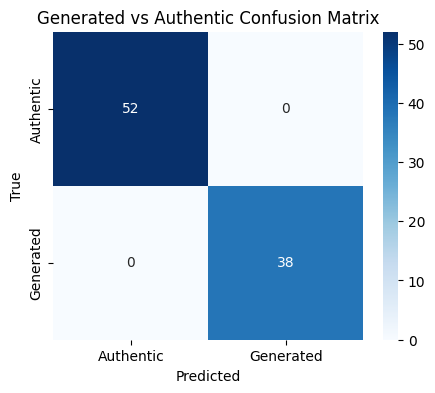

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
def limit_per_author(df, max_per_author=10):
    return df.groupby("author", group_keys=False).apply(lambda x: x.sample(n=min(len(x), max_per_author), random_state=42))


# === Best hyperparameters (reuse from before) ===
best_params = {
    'max_features': 4619,
    'n_layers': 1,
    'neurons': 567,
    'activation': 'tanh',
    'dropout_rate': 0.3406819279083615,
    'optimizer': 'rmsprop',
    'lr': 0.0007878787378953067,
    'l2_reg': 3.145848564707723e-05,
    'n_epochs': 41,
    'min_df': 3,
    'max_df': 0.8904674508605334,
    'ngram_range': (1, 1)
}


# === Load datasets ===
train_csv = "cleaned_songs.csv"
eval_csv = "../author_songs_created_using_styles_idf_stop_words_removed.csv"

df_authentic = pd.read_csv(train_csv)
df_authentic['song_text'] = df_authentic['song_text'].str.lower()
df_authentic['is_generated'] = 0  # Authentic songs

df_generated = pd.read_csv(eval_csv)
df_generated['new_song'] = df_generated['new_song'].str.lower()
df_generated.rename(columns={'new_song': 'song_text'}, inplace=True)
df_generated['is_generated'] = 1  # Generated songs

# Combine datasets

df_authentic_limited = limit_per_author(df_authentic, max_per_author=10)
df_generated_limited = limit_per_author(df_generated, max_per_author=10)

print(f"Authentic songs after limiting: {len(df_authentic_limited)}")
print(f"Generated songs after limiting: {len(df_generated_limited)}")

# === Combine datasets ===
df_all = pd.concat([
    df_authentic_limited[['song_text', 'author', 'is_generated']],
    df_generated_limited[['song_text', 'author', 'is_generated']]
], ignore_index=True)

print(f"Combined dataset size after limiting: {len(df_all)}")

print(f"Combined dataset size: {len(df_all)}")


# === Filter out authors with too few examples (optional but recommended) ===
author_counts = df_all['author'].value_counts()
valid_authors = author_counts[author_counts >= 10].index
df_all = df_all[df_all['author'].isin(valid_authors)]
print(f"Dataset size after filtering authors with <10 samples: {len(df_all)}")
print(f"Remaining authors: {len(valid_authors)}")


# === Vectorize text ===
vectorizer = TfidfVectorizer(
    max_features=best_params['max_features'],
    ngram_range=best_params['ngram_range'],
    min_df=best_params['min_df'],
    max_df=best_params['max_df']
)
X = vectorizer.fit_transform(df_all['song_text']).toarray()

# === Encode labels ===
label_encoder = LabelEncoder()
y_author = label_encoder.fit_transform(df_all['author'])
y_generated = df_all['is_generated'].values



X_train, X_test, y_auth_train, y_auth_test, y_gen_train, y_gen_test = train_test_split(
    X, y_author, y_generated, test_size=0.2, random_state=42, stratify=y_author
)


# === Build dual-output model ===
input_layer = layers.Input(shape=(X_train.shape[1],))

x = input_layer
for i in range(best_params['n_layers']):
    x = layers.Dense(
        best_params['neurons'],
        activation=best_params['activation'],
        kernel_regularizer=regularizers.l2(best_params['l2_reg'])
    )(x)
    x = layers.Dropout(best_params['dropout_rate'])(x)

# Two separate heads
author_output = layers.Dense(len(label_encoder.classes_), activation="softmax", name="author_output")(x)
generated_output = layers.Dense(1, activation="sigmoid", name="generated_output")(x)

model = keras.Model(inputs=input_layer, outputs=[author_output, generated_output])

optimizer = keras.optimizers.RMSprop(learning_rate=best_params['lr'])
model.compile(
    optimizer=optimizer,
    loss={
        "author_output": "sparse_categorical_crossentropy",
        "generated_output": "binary_crossentropy"
    },
    metrics={
        "author_output": "accuracy",
        "generated_output": "accuracy"
    }
)

model.summary()

# === Train ===
history = model.fit(
    X_train,
    {"author_output": y_auth_train, "generated_output": y_gen_train},
    validation_split=0.1,
    epochs=best_params['n_epochs'],
    batch_size=32,
    verbose=1
)


# === Evaluate ===
pred_auth, pred_gen = model.predict(X_test, verbose=0)
y_auth_pred = np.argmax(pred_auth, axis=1)
y_gen_pred = (pred_gen > 0.5).astype(int).flatten()

print("\n=== Generated vs Authentic Classification ===")
print(classification_report(y_gen_test, y_gen_pred, target_names=["Authentic", "Generated"]))

print("\n=== Author Prediction ===")
print(classification_report(y_auth_test, y_auth_pred, target_names=label_encoder.classes_))

# Weighted F1 for both
f1_author = f1_score(y_auth_test, y_auth_pred, average="weighted")
f1_gen = f1_score(y_gen_test, y_gen_pred, average="weighted")
print(f"\nWeighted F1 - Author: {f1_author:.4f}, Generated/Authentic: {f1_gen:.4f}")


# === Confusion matrix for authenticity ===
cm_gen = tf.math.confusion_matrix(y_gen_test, y_gen_pred).numpy()
plt.figure(figsize=(5,4))
sns.heatmap(cm_gen, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Authentic", "Generated"], yticklabels=["Authentic", "Generated"])
plt.title('Generated vs Authentic Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Num GPUs Available: 0
Authentic songs after limiting: 1022
Generated songs after limiting: 201
Combined dataset size after limiting: 1223
Combined dataset size: 1223
Dataset size after filtering authors with <10 samples: 1159
Remaining authors: 23


/tmp/ipykernel_11389/3067345403.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("author", group_keys=False).apply(lambda x: x.sample(n=min(len(x), max_per_author), random_state=42))
/tmp/ipykernel_11389/3067345403.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("author", group_keys=False).apply(lambda x: x.sample(n=min(len(x), max_per_author), random_state=42))


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 4619)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 567)       │  2,619,540 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 567)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ author_output       │ (None, 23)        │     13,064 │ dropout_6[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generated_output    │ (None, 1)         │        568 │ dropout_6[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,633,172 (10.04 MB)

 Trainable params: 2,633,172 (10.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - author_output_accuracy: 0.1535 - author_output_loss: 3.0544 - generated_output_accuracy: 0.8405 - generated_output_loss: 0.4858 - loss: 3.5861 - val_author_output_accuracy: 0.2688 - val_author_output_loss: 2.9609 - val_generated_output_accuracy: 0.9140 - val_generated_output_loss: 0.3191 - val_loss: 3.3095
Epoch 2/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - author_output_accuracy: 0.3609 - author_output_loss: 2.8088 - generated_output_accuracy: 0.8561 - generated_output_loss: 0.3174 - loss: 3.1588 - val_author_output_accuracy: 0.2796 - val_author_output_loss: 2.8201 - val_generated_output_accuracy: 0.9140 - val_generated_output_loss: 0.2255 - val_loss: 3.0755
Epoch 3/41
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - author_output_accuracy: 0.4580 - author_output_loss: 2.5727 - generated_output_accuracy: 0.9029 - generated_output_loss: 0.2122 - loss: 2.8302 - val_author_output_accuracy: 0.3226 - val_author_output_loss: 2.6823 - val_genera

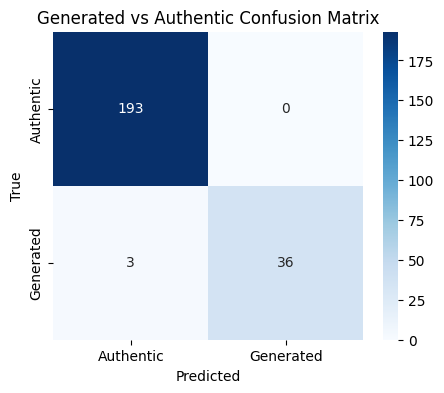

In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
def limit_per_author(df, max_per_author=10):
    return df.groupby("author", group_keys=False).apply(lambda x: x.sample(n=min(len(x), max_per_author), random_state=42))


# === Best hyperparameters (reuse from before) ===
best_params = {
    'max_features': 4619,
    'n_layers': 1,
    'neurons': 567,
    'activation': 'tanh',
    'dropout_rate': 0.3406819279083615,
    'optimizer': 'rmsprop',
    'lr': 0.0007878787378953067,
    'l2_reg': 3.145848564707723e-05,
    'n_epochs': 41,
    'min_df': 3,
    'max_df': 0.8904674508605334,
    'ngram_range': (1, 1)
}


# === Load datasets ===
train_csv = "cleaned_songs.csv"
eval_csv = "../author_songs_created_using_styles_idf_stop_words_removed_claude_0.csv"

df_authentic = pd.read_csv(train_csv)
df_authentic['song_text'] = df_authentic['song_text'].str.lower()
df_authentic['is_generated'] = 0  # Authentic songs

df_generated = pd.read_csv(eval_csv)
df_generated['new_song'] = df_generated['new_song'].str.lower()
df_generated.rename(columns={'new_song': 'song_text'}, inplace=True)
df_generated['is_generated'] = 1  # Generated songs

# Combine datasets

df_authentic_limited = limit_per_author(df_authentic, max_per_author=100)
df_generated_limited = limit_per_author(df_generated, max_per_author=100)

print(f"Authentic songs after limiting: {len(df_authentic_limited)}")
print(f"Generated songs after limiting: {len(df_generated_limited)}")

# === Combine datasets ===
df_all = pd.concat([
    df_authentic_limited[['song_text', 'author', 'is_generated']],
    df_generated_limited[['song_text', 'author', 'is_generated']]
], ignore_index=True)

print(f"Combined dataset size after limiting: {len(df_all)}")

print(f"Combined dataset size: {len(df_all)}")


# === Filter out authors with too few examples (optional but recommended) ===
author_counts = df_all['author'].value_counts()
valid_authors = author_counts[author_counts >= 10].index
df_all = df_all[df_all['author'].isin(valid_authors)]
print(f"Dataset size after filtering authors with <10 samples: {len(df_all)}")
print(f"Remaining authors: {len(valid_authors)}")


# === Vectorize text ===
vectorizer = TfidfVectorizer(
    max_features=best_params['max_features'],
    ngram_range=best_params['ngram_range'],
    min_df=best_params['min_df'],
    max_df=best_params['max_df']
)
X = vectorizer.fit_transform(df_all['song_text']).toarray()

# === Encode labels ===
label_encoder = LabelEncoder()
y_author = label_encoder.fit_transform(df_all['author'])
y_generated = df_all['is_generated'].values



X_train, X_test, y_auth_train, y_auth_test, y_gen_train, y_gen_test = train_test_split(
    X, y_author, y_generated, test_size=0.2, random_state=42, stratify=y_author
)


# === Build dual-output model ===
input_layer = layers.Input(shape=(X_train.shape[1],))

x = input_layer
for i in range(best_params['n_layers']):
    x = layers.Dense(
        best_params['neurons'],
        activation=best_params['activation'],
        kernel_regularizer=regularizers.l2(best_params['l2_reg'])
    )(x)
    x = layers.Dropout(best_params['dropout_rate'])(x)

# Two separate heads
author_output = layers.Dense(len(label_encoder.classes_), activation="softmax", name="author_output")(x)
generated_output = layers.Dense(1, activation="sigmoid", name="generated_output")(x)

model = keras.Model(inputs=input_layer, outputs=[author_output, generated_output])

optimizer = keras.optimizers.RMSprop(learning_rate=best_params['lr'])
model.compile(
    optimizer=optimizer,
    loss={
        "author_output": "sparse_categorical_crossentropy",
        "generated_output": "binary_crossentropy"
    },
    metrics={
        "author_output": "accuracy",
        "generated_output": "accuracy"
    }
)

model.summary()

# === Train ===
history = model.fit(
    X_train,
    {"author_output": y_auth_train, "generated_output": y_gen_train},
    validation_split=0.1,
    epochs=best_params['n_epochs'],
    batch_size=32,
    verbose=1
)


# === Evaluate ===
pred_auth, pred_gen = model.predict(X_test, verbose=0)
y_auth_pred = np.argmax(pred_auth, axis=1)
y_gen_pred = (pred_gen > 0.5).astype(int).flatten()

print("\n=== Generated vs Authentic Classification ===")
print(classification_report(y_gen_test, y_gen_pred, target_names=["Authentic", "Generated"]))

print("\n=== Author Prediction ===")
print(classification_report(y_auth_test, y_auth_pred, target_names=label_encoder.classes_))

# Weighted F1 for both
f1_author = f1_score(y_auth_test, y_auth_pred, average="weighted")
f1_gen = f1_score(y_gen_test, y_gen_pred, average="weighted")
print(f"\nWeighted F1 - Author: {f1_author:.4f}, Generated/Authentic: {f1_gen:.4f}")


# === Confusion matrix for authenticity ===
cm_gen = tf.math.confusion_matrix(y_gen_test, y_gen_pred).numpy()
plt.figure(figsize=(5,4))
sns.heatmap(cm_gen, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Authentic", "Generated"], yticklabels=["Authentic", "Generated"])
plt.title('Generated vs Authentic Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Num GPUs Available: 0
Authentic songs after limiting: 1022
Generated songs after limiting: 255
Combined dataset size after limiting: 1277
Combined dataset size: 1277
Dataset size after filtering authors with <10 samples: 1213
Remaining authors: 23


/tmp/ipykernel_11389/3067345403.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("author", group_keys=False).apply(lambda x: x.sample(n=min(len(x), max_per_author), random_state=42))
/tmp/ipykernel_11389/3067345403.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby("author", group_keys=False).apply(lambda x: x.sample(n=min(len(x), max_per_author), random_state=42))


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 4619)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 567)       │  2,619,540 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 567)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ author_output       │ (None, 23)        │     13,064 │ dropout_9[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ generated_output    │ (None, 1)         │        568 │ dropout_9[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,633,172 (10.04 MB)

 Trainable params: 2,633,172 (10.04 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/41
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - author_output_accuracy: 0.1684 - author_output_loss: 3.0419 - generated_output_accuracy: 0.8076 - generated_output_loss: 0.5144 - loss: 3.5902 - val_author_output_accuracy: 0.1959 - val_author_output_loss: 2.9063 - val_generated_output_accuracy: 0.8247 - val_generated_output_loss: 0.3539 - val_loss: 3.3805
Epoch 2/41
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - author_output_accuracy: 0.3368 - author_output_loss: 2.7851 - generated_output_accuracy: 0.8316 - generated_output_loss: 0.3323 - loss: 3.1571 - val_author_output_accuracy: 0.2165 - val_author_output_loss: 2.7415 - val_generated_output_accuracy: 0.8454 - val_generated_output_loss: 0.2360 - val_loss: 3.1229
Epoch 3/41
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - author_output_accuracy: 0.4903 - author_output_loss: 2.5568 - generated_output_accuracy: 0.9107 - generated_output_loss: 0.2231 - loss: 2.8055 - val_author_output_accuracy: 0.3505 - val_author_output_loss: 2.5918 - val_genera

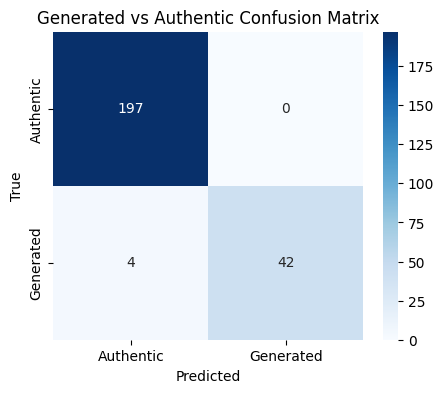

In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
def limit_per_author(df, max_per_author=10):
    return df.groupby("author", group_keys=False).apply(lambda x: x.sample(n=min(len(x), max_per_author), random_state=42))


# === Best hyperparameters (reuse from before) ===
best_params = {
    'max_features': 4619,
    'n_layers': 1,
    'neurons': 567,
    'activation': 'tanh',
    'dropout_rate': 0.3406819279083615,
    'optimizer': 'rmsprop',
    'lr': 0.0007878787378953067,
    'l2_reg': 3.145848564707723e-05,
    'n_epochs': 41,
    'min_df': 3,
    'max_df': 0.8904674508605334,
    'ngram_range': (1, 1)
}


# === Load datasets ===
train_csv = "cleaned_songs.csv"
eval_csv = "../author_songs_created_using_styles_idf_stop_words_removed_claude_0.csv"

df_authentic = pd.read_csv(train_csv)
df_authentic['song_text'] = df_authentic['song_text'].str.lower()
df_authentic['is_generated'] = 0  # Authentic songs

df_generated = pd.read_csv(eval_csv)
df_generated['new_song'] = df_generated['new_song'].str.lower()
df_generated.rename(columns={'new_song': 'song_text'}, inplace=True)
df_generated['is_generated'] = 1  # Generated songs

# Combine datasets

df_authentic_limited = limit_per_author(df_authentic, max_per_author=100)
df_generated_limited = limit_per_author(df_generated, max_per_author=100)

print(f"Authentic songs after limiting: {len(df_authentic_limited)}")
print(f"Generated songs after limiting: {len(df_generated_limited)}")

# === Combine datasets ===
df_all = pd.concat([
    df_authentic_limited[['song_text', 'author', 'is_generated']],
    df_generated_limited[['song_text', 'author', 'is_generated']]
], ignore_index=True)

print(f"Combined dataset size after limiting: {len(df_all)}")

print(f"Combined dataset size: {len(df_all)}")


# === Filter out authors with too few examples (optional but recommended) ===
author_counts = df_all['author'].value_counts()
valid_authors = author_counts[author_counts >= 10].index
df_all = df_all[df_all['author'].isin(valid_authors)]
print(f"Dataset size after filtering authors with <10 samples: {len(df_all)}")
print(f"Remaining authors: {len(valid_authors)}")


# === Vectorize text ===
vectorizer = TfidfVectorizer(
    max_features=best_params['max_features'],
    ngram_range=best_params['ngram_range'],
    min_df=best_params['min_df'],
    max_df=best_params['max_df']
)
X = vectorizer.fit_transform(df_all['song_text']).toarray()

# === Encode labels ===
label_encoder = LabelEncoder()
y_author = label_encoder.fit_transform(df_all['author'])
y_generated = df_all['is_generated'].values



X_train, X_test, y_auth_train, y_auth_test, y_gen_train, y_gen_test = train_test_split(
    X, y_author, y_generated, test_size=0.2, random_state=42, stratify=y_author
)


# === Build dual-output model ===
input_layer = layers.Input(shape=(X_train.shape[1],))

x = input_layer
for i in range(best_params['n_layers']):
    x = layers.Dense(
        best_params['neurons'],
        activation=best_params['activation'],
        kernel_regularizer=regularizers.l2(best_params['l2_reg'])
    )(x)
    x = layers.Dropout(best_params['dropout_rate'])(x)

# Two separate heads
author_output = layers.Dense(len(label_encoder.classes_), activation="softmax", name="author_output")(x)
generated_output = layers.Dense(1, activation="sigmoid", name="generated_output")(x)

model = keras.Model(inputs=input_layer, outputs=[author_output, generated_output])

optimizer = keras.optimizers.RMSprop(learning_rate=best_params['lr'])
model.compile(
    optimizer=optimizer,
    loss={
        "author_output": "sparse_categorical_crossentropy",
        "generated_output": "binary_crossentropy"
    },
    metrics={
        "author_output": "accuracy",
        "generated_output": "accuracy"
    }
)

model.summary()

# === Train ===
history = model.fit(
    X_train,
    {"author_output": y_auth_train, "generated_output": y_gen_train},
    validation_split=0.1,
    epochs=best_params['n_epochs'],
    batch_size=32,
    verbose=1
)


# === Evaluate ===
pred_auth, pred_gen = model.predict(X_test, verbose=0)
y_auth_pred = np.argmax(pred_auth, axis=1)
y_gen_pred = (pred_gen > 0.5).astype(int).flatten()

print("\n=== Generated vs Authentic Classification ===")
print(classification_report(y_gen_test, y_gen_pred, target_names=["Authentic", "Generated"]))

print("\n=== Author Prediction ===")
print(classification_report(y_auth_test, y_auth_pred, target_names=label_encoder.classes_))

# Weighted F1 for both
f1_author = f1_score(y_auth_test, y_auth_pred, average="weighted")
f1_gen = f1_score(y_gen_test, y_gen_pred, average="weighted")
print(f"\nWeighted F1 - Author: {f1_author:.4f}, Generated/Authentic: {f1_gen:.4f}")


# === Confusion matrix for authenticity ===
cm_gen = tf.math.confusion_matrix(y_gen_test, y_gen_pred).numpy()
plt.figure(figsize=(5,4))
sns.heatmap(cm_gen, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Authentic", "Generated"], yticklabels=["Authentic", "Generated"])
plt.title('Generated vs Authentic Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
